# Agentic fighters

## Exercise 4 - Architectures: hands-on

Ahora es vuestro turno!

Vamos a dejar un buen rato para que podamos aplicar lo que hemos aprendido sobre LangGraph e intentar diseñar algunas de las arquitecturas que pueden ser más útiles. Vamos a por ello!

_(Cómo podrías utilizar estas estructuras para hacer una app de Agentic Fighters?)_

### Augmented LLM

![Augmented LLM](./../images/Augmented_LLM.png)

In [1]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [2]:
# Schema for structured output
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol relationship
This query is relevant because it seeks to understand the connection between calcium scores from CT scans, which indicate coronary artery disease, and high cholesterol levels, which are a risk factor for heart disease.


In [3]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

In [4]:
# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_XUbGzAvoo6EKOc6J9owX5bIw',
  'type': 'tool_call'}]

- Cuándo utilizar esta arquitectura?

- Algunos ejemplos donde puede ser útil:

-----

### Prompt chaining

![Prompt chaining](./../images/Prompt_chaining.png)

Each LLM call processes the output of the previous one:

- E.g., when decomposing a task into multiple LLM calls has benefit.

Example:

- Take a topic, LLM makes a joke, check the joke, improve it twice

In [5]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [6]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

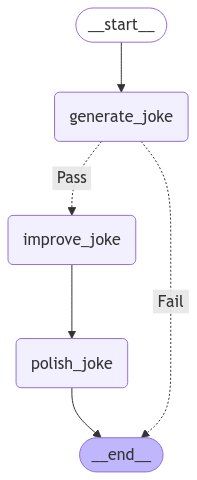

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse and make sure it didn’t click away!

--- --- ---

Final joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse and make sure it didn’t click away! But little did it know, the mouse was actually a hacker planning to steal all the cat videos!


-----

### Routing

![Routing](./../images/Routing.png)

Routing classifies an input and directs it to a specialized followup task.

- E.g., when routing a question to different retrieval systems.

Example:

- Route an input between joke, story, and poem

In [9]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [10]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

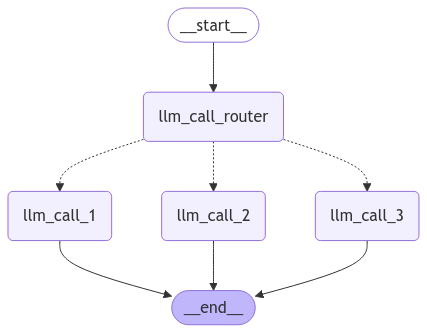

In [12]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [13]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


- Cuándo utilizar esta arquitectura?

- Algunos ejemplos donde puede ser útil:

-----

### Parallelization

![Parallelization](./../images/Parallelization.png)

Sub-tasks can be parallelized.

- E.g., when you want multi-perspectives for one task  multi-query for RAG.
- E.g., when independent tasks can be performed w/ different prompts.

Example:

- Take a topic, create a joke, story, and poem

In [14]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [15]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

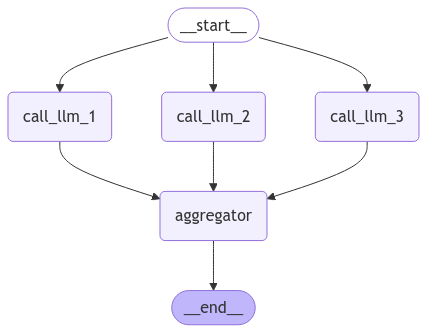

In [16]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [17]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
**The Secret Society of Whiskers**

In the quaint little town of Willowbrook, where the streets were lined with cobblestones and the air was filled with the scent of blooming lilacs, there existed a secret society known only to the feline residents. This society, known as the "Whiskers," was composed of the town's most clever and adventurous cats, each with their own unique talents.

At the heart of this society was a sleek black cat named Midnight. With her piercing green eyes and a coat that shimmered like the night sky, Midnight was the leader of the Whiskers. She was known for her intelligence and bravery, often leading her fellow cats on daring escapades. Her best friend, a fluffy orange tabby named Ginger, was the society's strategist, always coming up with clever plans to outsmart the humans and other animals in town.

One sunny afternoon, as the cats lounged in the sun-drenched alley behind the old bakery, Midnight gathered her

- Cuándo utilizar esta arquitectura?

- Algunos ejemplos donde puede ser útil:

-----

### Orchestrator-workers

![Orchestrator-workers](./../images/Orchestrator-workers.png)

Orchestrator breaks down a task and delegates each sub-task to workers.

- E.g., planning a report where LLM can determine the number of sections.

Example

- Take a topic, plan a report of section, have each worker write a section

In [18]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [19]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [20]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

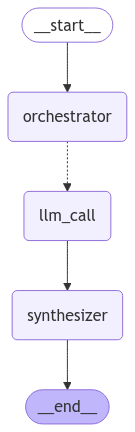

In [21]:
from langgraph.constants import Send

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [22]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

### Introduction to LLM Scaling Laws

Large Language Models (LLMs) have revolutionized the field of artificial intelligence (AI) by demonstrating remarkable capabilities in natural language understanding and generation. As these models have grown in size and complexity, researchers have observed certain empirical relationships that govern their performance relative to their scale. These relationships are commonly referred to as LLM scaling laws. 

Scaling laws describe how various performance metrics—such as accuracy, fluency, and generalization—improve as a function of model size, dataset size, and training duration. Specifically, they provide insights into how increasing the number of parameters in a model or the volume of training data can lead to diminishing returns in performance. Understanding these laws is crucial for optimizing the design and deployment of LLMs, as they inform decisions regarding resource allocation, model architecture, and training strategies.

The significance of LLM scaling laws extends beyond mere performance metrics; they offer a framework for predicting the capabilities of future models based on current trends. This predictive power is invaluable for researchers and practitioners in the AI community, as it allows for more informed planning and investment in AI technologies. Moreover, scaling laws can help identify the thresholds at which additional resources yield minimal improvements, guiding the development of more efficient models.

The motivation behind studying LLM scaling laws stems from the rapid advancements in AI and the increasing demand for more capable and efficient language models. As organizations and researchers strive to push the boundaries of what LLMs can achieve, understanding the underlying principles of scaling becomes essential. By elucidating the relationship between model size, data, and performance, scaling laws not only enhance our theoretical understanding of LLMs but also pave the way for practical applications that can benefit society at large.

In summary, LLM scaling laws are a critical area of study within the AI landscape, providing insights that drive the development of more powerful and efficient language models. As the field continues to evolve, a deeper understanding of these laws will be instrumental in shaping the future of artificial intelligence.

---

### Historical Context and Description

The evolution of language models has been a remarkable journey marked by significant milestones and breakthroughs that have shaped the current landscape of natural language processing (NLP). The development of language models can be traced back to the early days of computational linguistics, where rule-based systems dominated the field. These systems relied heavily on handcrafted rules and linguistic knowledge, which limited their scalability and adaptability.

#### Early Language Models

In the 1980s and 1990s, statistical methods began to emerge, leading to the development of n-gram models. These models utilized the probabilities of word sequences based on their frequency in a given corpus, allowing for a more data-driven approach to language processing. However, n-gram models struggled with long-range dependencies and required extensive amounts of data to perform effectively.

#### The Rise of Neural Networks

The introduction of neural networks in the 2000s marked a pivotal shift in language modeling. The advent of recurrent neural networks (RNNs) allowed for the processing of sequences of varying lengths, enabling models to capture contextual information more effectively. Long Short-Term Memory (LSTM) networks, introduced in 1997, further improved the ability to retain information over longer sequences, addressing some of the limitations of traditional RNNs.

#### Breakthroughs in Pre-training and Transfer Learning

The landscape of language models underwent another transformation with the introduction of pre-training and transfer learning techniques. In 2018, the release of the BERT (Bidirectional Encoder Representations from Transformers) model by Google marked a significant breakthrough. BERT utilized a transformer architecture, which allowed for bidirectional context understanding and significantly improved performance on various NLP tasks. This model demonstrated the effectiveness of pre-training on large corpora followed by fine-tuning on specific tasks, setting a new standard in the field.

#### The Emergence of Large Language Models (LLMs)

The development of large language models (LLMs) can be traced to the scaling of transformer architectures and the availability of vast amounts of data and computational resources. OpenAI's GPT-2, released in 2019, showcased the potential of scaling up model size and training data, achieving impressive results in text generation and comprehension. This was followed by the release of GPT-3 in 2020, which further pushed the boundaries with 175 billion parameters, demonstrating the power of LLMs in generating coherent and contextually relevant text across a wide range of topics.

#### Understanding Scaling Laws

As researchers explored the capabilities of LLMs, they began to uncover the principles of scaling laws, which describe how model performance improves with increased size, data, and training time. These laws have become a foundational aspect of modern NLP research, guiding the development of even larger models and informing best practices for training and deployment. The insights gained from scaling laws have led to a deeper understanding of the trade-offs between model complexity, resource requirements, and performance, shaping the future of language modeling.

In summary, the historical context of language models reveals a trajectory from rule-based systems to sophisticated neural architectures, culminating in the development of LLMs. Key milestones, including the advent of statistical methods, the rise of neural networks, and the breakthroughs in pre-training and scaling, have collectively contributed to the current understanding of language models and their capabilities. As the field continues to evolve, the lessons learned from this history will undoubtedly inform future advancements in natural language processing.

---

### Mathematical Foundations of Scaling Laws

Scaling laws are fundamental principles that describe how various performance metrics of models, particularly in machine learning and artificial intelligence, change with respect to the size of the model and the amount of data used for training. Understanding these laws is crucial for optimizing model performance and resource allocation in computational tasks. This section delves into the mathematical principles that govern these relationships, providing a framework for analyzing how model size and data size interact to influence performance outcomes.

#### 1. Definitions and Key Concepts

At the core of scaling laws is the relationship between three primary variables: model size (M), data size (D), and performance metrics (P). Performance metrics can include accuracy, loss, or other relevant indicators of model effectiveness. The scaling law can often be expressed in a functional form, such as:

\[ P = f(M, D) \]

where \( f \) is a function that captures the interaction between model size and data size. 

#### 2. Power Law Relationships

One of the most common forms of scaling laws observed in practice is the power law relationship, which can be expressed as:

\[ P \propto M^a \cdot D^b \]

where \( a \) and \( b \) are constants that depend on the specific task and model architecture. This relationship suggests that performance improves multiplicatively with increases in model size and data size, highlighting the importance of both factors in achieving optimal results.

#### 3. Dimensional Analysis

Dimensional analysis provides a powerful tool for understanding scaling laws. By analyzing the dimensions of the variables involved, we can derive relationships that are invariant under changes in scale. For instance, if we consider the dimensions of model parameters, data points, and performance metrics, we can establish a framework that predicts how changes in one dimension affect the others.

#### 4. Empirical Observations

Empirical studies have shown that scaling laws often exhibit diminishing returns. As model size and data size increase, the incremental gains in performance tend to decrease. This phenomenon can be mathematically modeled using logarithmic functions, leading to formulations such as:

\[ \log(P) = c_1 \log(M) + c_2 \log(D) + c_3 \]

where \( c_1 \) and \( c_2 \) are coefficients that reflect the sensitivity of performance to changes in model and data size, respectively, and \( c_3 \) is a constant.

#### 5. Implications for Model Design

Understanding the mathematical foundations of scaling laws has significant implications for model design and training strategies. It informs decisions regarding the trade-offs between increasing model complexity and the availability of training data. For instance, in scenarios where data is scarce, it may be more beneficial to optimize model architecture rather than simply increasing the number of parameters.

#### 6. Conclusion

The exploration of scaling laws through mathematical principles provides valuable insights into the interplay between model size, data size, and performance metrics. By leveraging these insights, practitioners can make informed decisions that enhance model efficiency and effectiveness, ultimately leading to better outcomes in various applications of machine learning and artificial intelligence. Further research into the nuances of these relationships will continue to refine our understanding and application of scaling laws in practice.

---

### Empirical Evidence and Case Studies

The exploration of scaling laws in large language models (LLMs) has garnered significant attention in recent years, particularly with the advent of models such as OpenAI's GPT-3. Empirical studies and experiments have provided robust evidence supporting the notion that as the size of LLMs increases—whether in terms of parameters, training data, or computational resources—their performance on various natural language processing (NLP) tasks tends to improve in a predictable manner.

One of the most notable studies in this domain is the work conducted by Kaplan et al. (2020), which systematically analyzed the relationship between model size, dataset size, and performance across a range of benchmarks. Their findings indicated that larger models consistently outperformed smaller counterparts, with performance improvements following a power-law distribution. This scaling behavior was particularly evident in tasks such as language modeling, text completion, and question answering, where larger models demonstrated enhanced capabilities in generating coherent and contextually relevant text.

In the case of GPT-3, which boasts 175 billion parameters, empirical evidence highlights its remarkable ability to perform few-shot and zero-shot learning. Brown et al. (2020) showcased that GPT-3 could generate high-quality text outputs across diverse tasks without the need for task-specific fine-tuning. This capability is attributed to the model's extensive training on a diverse dataset, which allows it to generalize effectively from limited examples. The performance of GPT-3 on benchmarks such as the SuperGLUE and the LAMBADA dataset further illustrates the advantages of scaling, as it achieved state-of-the-art results that surpassed those of its predecessors.

Moreover, case studies involving the application of GPT-3 in real-world scenarios have provided additional insights into the practical implications of scaling laws. For instance, in creative writing, GPT-3 has been employed to assist authors in generating story ideas, drafting content, and even composing poetry. The model's ability to produce human-like text has led to discussions about its potential impact on industries such as publishing, marketing, and customer service.

Another empirical investigation by Wei et al. (2021) examined the effects of scaling on model robustness and generalization. Their research indicated that larger models not only performed better on standard benchmarks but also exhibited improved resilience to adversarial inputs and noise. This finding underscores the importance of scaling in enhancing the reliability of LLMs in practical applications.

In summary, the empirical evidence and case studies surrounding scaling laws in LLMs, particularly with models like GPT-3, demonstrate a clear trend: as models scale in size and complexity, their performance on a wide array of tasks improves significantly. This relationship not only reinforces the theoretical underpinnings of scaling laws but also highlights the transformative potential of LLMs in various domains, paving the way for future advancements in artificial intelligence.

---

### Implications for Model Development

The emergence of scaling laws in the development of large language models (LLMs) has profound implications for their design, training, and overall resource allocation. Scaling laws, which describe the relationship between model size, data quantity, and performance, provide a framework for understanding how incremental increases in these dimensions can lead to significant improvements in model capabilities. This section discusses the key considerations for model development in light of these scaling laws.

#### 1. Model Architecture and Size

Scaling laws suggest that larger models tend to perform better, but the relationship is not linear. As such, model architects must carefully consider the trade-offs between model size and computational efficiency. While increasing the number of parameters can enhance performance, it also demands exponentially more computational resources and energy. Therefore, developers should explore innovative architectures that maximize performance without a proportional increase in size. Techniques such as model distillation, pruning, and quantization can help maintain high performance while reducing resource requirements.

#### 2. Data Utilization

The effectiveness of scaling laws is heavily dependent on the quality and quantity of training data. As models scale, they require vast amounts of diverse and high-quality data to realize their full potential. This necessitates a strategic approach to data collection and curation, ensuring that the datasets used for training are representative and comprehensive. Additionally, leveraging synthetic data generation and transfer learning can help mitigate data scarcity issues, allowing for more efficient training processes.

#### 3. Resource Allocation

Given the substantial computational resources required for training large models, organizations must adopt a strategic approach to resource allocation. This includes investing in high-performance computing infrastructure, optimizing cloud resource usage, and considering the environmental impact of large-scale training. Organizations should also evaluate the cost-benefit ratio of scaling up models versus optimizing existing ones, as smaller, well-tuned models can sometimes outperform larger counterparts in specific applications.

#### 4. Optimization Techniques

As models grow in size, the complexity of training them increases, necessitating the development of advanced optimization techniques. Researchers should focus on improving training algorithms to enhance convergence rates and stability. Techniques such as mixed-precision training, gradient accumulation, and adaptive learning rates can significantly reduce training time and resource consumption. Furthermore, exploring distributed training methods can help manage the computational load across multiple devices, making it feasible to train larger models efficiently.

#### 5. Ethical and Societal Considerations

The implications of scaling laws extend beyond technical considerations; they also raise ethical and societal questions. As LLMs become more powerful, the potential for misuse increases, necessitating a focus on responsible AI development. Developers must prioritize transparency, fairness, and accountability in their models, ensuring that scaling efforts do not exacerbate existing biases or lead to harmful outcomes. Engaging with stakeholders and incorporating ethical guidelines into the model development process is essential for fostering trust and ensuring the positive impact of LLMs on society.

### Conclusion

In summary, scaling laws play a critical role in shaping the future of LLM development. By understanding and leveraging these laws, researchers and developers can make informed decisions regarding model architecture, data utilization, resource allocation, optimization techniques, and ethical considerations. As the field continues to evolve, a balanced approach that prioritizes both performance and responsibility will be essential for the sustainable advancement of large language models.

---

### Challenges and Limitations

The rapid advancement and deployment of Large Language Models (LLMs) have brought significant benefits across various domains, yet they are not without their challenges and limitations. This section delves into the primary obstacles associated with scaling LLMs, focusing on computational costs, environmental impact, and the phenomenon of diminishing returns.

#### Computational Costs

One of the most pressing challenges in scaling LLMs is the substantial computational resources required for training and inference. As models grow in size and complexity, the demand for high-performance hardware, such as GPUs and TPUs, increases exponentially. This escalation in resource requirements translates to higher financial costs for organizations, particularly for those without access to substantial funding or infrastructure. Additionally, the time required for training these models can be prohibitive, often taking weeks or even months, which can delay deployment and innovation.

#### Environmental Impact

The environmental implications of training large-scale models cannot be overlooked. The energy consumption associated with the computational power needed for LLMs contributes to a significant carbon footprint. Research indicates that training a single large model can emit as much carbon as the lifetime emissions of several cars. As awareness of climate change and sustainability grows, the tech industry faces increasing scrutiny regarding the environmental impact of its operations. This has led to calls for more energy-efficient algorithms and practices, as well as a push towards utilizing renewable energy sources in data centers.

#### Diminishing Returns

Another critical limitation in scaling LLMs is the concept of diminishing returns. While increasing the size of a model can lead to improvements in performance, these gains often become marginal beyond a certain point. As models reach a certain scale, the incremental benefits of adding more parameters or training data may not justify the associated costs. This raises important questions about the efficiency of resources and the potential for overfitting, where a model becomes too tailored to its training data and loses generalizability. Researchers are increasingly exploring alternative approaches, such as fine-tuning smaller models or leveraging transfer learning, to achieve competitive performance without the need for massive scale.

#### Conclusion

In summary, while the scaling of LLMs presents exciting opportunities for advancements in artificial intelligence, it is accompanied by significant challenges and limitations. Addressing computational costs, mitigating environmental impact, and understanding the implications of diminishing returns are critical for the sustainable development of LLM technologies. As the field continues to evolve, it will be essential for researchers and practitioners to navigate these challenges thoughtfully, ensuring that the benefits of LLMs can be realized without compromising ethical and environmental standards.

---

### Future Directions in LLM Research

As the field of large language models (LLMs) continues to evolve, several key trends and potential breakthroughs are anticipated that could significantly shape the landscape of AI research. This section explores the future directions in LLM scaling, the implications of scaling laws, and the broader context of AI advancements.

#### 1. Enhanced Scaling Laws

Recent research has underscored the importance of scaling laws in determining the performance of LLMs. Future investigations are likely to delve deeper into the mathematical underpinnings of these laws, potentially leading to more refined models that can predict performance improvements based on various scaling parameters, such as model size, dataset size, and training duration. This could enable researchers to optimize resource allocation and model architecture more effectively, paving the way for more efficient training processes.

#### 2. Multimodal Models

The integration of multimodal capabilities—where models can process and generate not just text but also images, audio, and video—is expected to be a significant trend in LLM research. Future LLMs may leverage advancements in computer vision and audio processing to create more holistic AI systems that can understand and generate content across different modalities. This could lead to breakthroughs in applications such as virtual assistants, content creation, and interactive AI systems that engage users in more dynamic ways.

#### 3. Efficiency and Sustainability

As LLMs grow in size and complexity, concerns regarding their environmental impact and computational efficiency are becoming increasingly prominent. Future research is likely to focus on developing more sustainable training methodologies, such as model distillation, pruning, and quantization techniques that reduce the resource footprint of LLMs without sacrificing performance. Innovations in hardware, such as specialized AI chips, may also play a crucial role in making LLM training more energy-efficient.

#### 4. Ethical and Responsible AI

The growing capabilities of LLMs raise important ethical considerations, including issues of bias, misinformation, and user privacy. Future research will need to address these challenges by developing frameworks for responsible AI deployment. This may involve creating more transparent models, implementing robust bias mitigation strategies, and establishing guidelines for the ethical use of LLMs in various applications. Collaborative efforts between researchers, policymakers, and industry stakeholders will be essential to navigate these complexities.

#### 5. Democratization of AI

As LLM technology matures, there is a strong potential for democratization, allowing a broader range of users and organizations to access and utilize these powerful tools. Future directions may include the development of user-friendly interfaces, open-source models, and community-driven initiatives that empower individuals and smaller entities to leverage LLMs for diverse applications. This shift could foster innovation and creativity across various sectors, from education to healthcare.

#### 6. Interdisciplinary Collaboration

The future of LLM research is likely to be characterized by increased interdisciplinary collaboration. As AI intersects with fields such as neuroscience, linguistics, and cognitive science, insights from these domains could inform the development of more sophisticated models that better mimic human-like understanding and reasoning. Such collaborations may lead to breakthroughs in natural language understanding and generation, enhancing the capabilities of LLMs.

In conclusion, the future of LLM research is poised for transformative advancements driven by enhanced scaling laws, multimodal integration, efficiency improvements, ethical considerations, democratization, and interdisciplinary collaboration. As researchers continue to push the boundaries of what is possible with LLMs, the implications for society, industry, and technology will be profound, necessitating ongoing dialogue and exploration in this rapidly evolving field.

---

### Conclusion and Description

In this report, we have explored the intricate dynamics of scaling laws associated with large language models (LLMs) and their implications for the future of artificial intelligence. Our analysis has revealed several key findings that underscore the significance of understanding these scaling laws as we advance in the field of AI.

Firstly, we established that the performance of LLMs improves predictably with increases in model size, data volume, and computational resources. This relationship highlights the potential for continued enhancements in model capabilities as we invest in larger datasets and more powerful hardware. However, it also raises critical questions about the sustainability and accessibility of such resources, particularly in light of environmental concerns and the economic implications of scaling up AI infrastructure.

Secondly, our findings indicate that while larger models tend to exhibit superior performance, they also come with diminishing returns. This suggests that there may be an optimal point of investment where the benefits of scaling begin to plateau. Understanding this threshold is crucial for researchers and organizations aiming to maximize the efficiency of their AI development efforts.

Moreover, we identified that the scaling laws are not uniform across all tasks and domains. Certain applications may benefit more from increased model size than others, indicating the need for a nuanced approach to model development that considers the specific requirements of different use cases. This insight encourages a more strategic allocation of resources, focusing on areas where scaling can yield the most significant advancements.

Lastly, the report emphasizes the importance of interdisciplinary collaboration in advancing our understanding of LLM scaling laws. Insights from fields such as cognitive science, linguistics, and ethics can inform the development of more robust and responsible AI systems. As we continue to push the boundaries of what LLMs can achieve, it is imperative that we do so with a comprehensive understanding of their capabilities and limitations.

In conclusion, the exploration of LLM scaling laws is not merely an academic exercise; it is a foundational aspect of shaping the future of AI. By grasping these principles, researchers and practitioners can better navigate the complexities of model development, ensuring that advancements in AI are both innovative and responsible. As we look ahead, a concerted effort to understand and apply these scaling laws will be essential in unlocking the full potential of artificial intelligence.

- Cuándo utilizar esta arquitectura?

- Algunos ejemplos donde puede ser útil:

-----

### Evaluator-optimizer

![Evaluator-optimizer](./../images/Evaluator-optimizer.png)

One LLM call generates a response while another provides evaluation and feedback in a loop.

- E.g., when grading the quality of responses from a RAG system (for hallucinations).

In [23]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [24]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [25]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

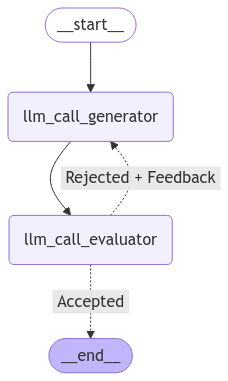

In [26]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [27]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


- Cuándo utilizar esta arquitectura?

- Algunos ejemplos donde puede ser útil:

-----

### Pure agent

![Pure agent](./../images/Pure_agent.png)

Agents plan, take actions (via tool-calling), and respond to feedback (in a loop).

- E.g., when solving open-ended problems that you cannot lay out as a workflow

In [28]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [29]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

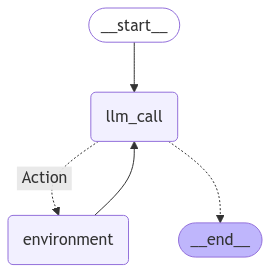

In [30]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [31]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_kr0YoxRkIQn28o5Eb0PuQ1zk)
 Call ID: call_kr0YoxRkIQn28o5Eb0PuQ1zk
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Cp9KlfT4MiCYtMKFnlI5BdOf)
 Call ID: call_Cp9KlfT4MiCYtMKFnlI5BdOf
  Args:
    a: 7
    b: 4
================================= Tool Message =================================

28
================================== Ai Message ==================================

The result of adding 3 and 4 is 7, and when you multiply that by 4, the final result is 28.
